In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, calculate_default_transform, reproject

plt.style.use("ggplot")

# Estimate annual harvest volume by fylke using SR16beta

**Running this notebook requires a high memory machine (e.g 48 GB).**

SR16beta inlcudes the layers `HOGSTAAR` (harvest year) and `VOLUB` harvest volume without bark (in m3/ha). The code below loops over the raw rasters for each fylke and performs the following calculations:

 1. Gets the years with harvesting in each fylke from the `HOGSTAAR` dataset.

 2. For each year in each fylke, extracts just the cells with harvesting from the `VOLUB` dataset.

 3. Reprojects the `VOLUB` dataset to an equal area projection and calculates the total harvested volume in each fylke in each year.

 4. Saves the result as a CSV.

In [2]:
# Raw data is already chunked by fylke
raw_path = (
    r"/home/jovyan/shared/common/oslofjord_modelling/nibio_skog/data/sr16beta/raw"
)
fylkes = [42, 34, 15, 18, 3, 11, 54, 50, 38, 46, 30]
data_dict = {
    "fylke": [],
    "year": [],
    "harvest_vol_m3": [],
}
for fylke in fylkes:
    # Read year and harvest volume rasters
    yr_tif = os.path.join(raw_path, f"sr16_{fylke}_SRRHOGSTAARbeta.tif")
    with rasterio.open(yr_tif) as src:
        yr_array = src.read(1)
    vol_tif = os.path.join(raw_path, f"sr16_{fylke}_SRRVOLUB_Hbeta.tif")
    with rasterio.open(vol_tif) as src:
        vol_array = src.read(1)

    # Get unique years with data
    years = [int(val) for val in np.unique(yr_array) if (val > 0) and ~np.isnan(val)]
    for year in years:
        print(fylke, year)

        # Make a copy of vol_array with only values for this year
        vol_yr_array = vol_array.copy()
        vol_yr_array[yr_array != year] = np.nan

        # Reproject to equal area for Norway using bilinear interpolation
        dst_crs = "EPSG:3035"  # ETRS89-extended / LAEA Europe
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height,
                "nodata": np.nan,
                "compress": "lzw",
            }
        )

        # Save a temp raster
        temp_path = r"/home/jovyan/shared/common/oslofjord_modelling/nibio_skog/data/sr16beta/temp.tif"
        with rasterio.open(temp_path, "w", **kwargs) as dst:
            reproject(
                source=vol_yr_array,
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear,
            )

        # Read the temp raster and calculate harvest volume. Original raster is in m3/ha
        with rasterio.open(temp_path) as src:
            val_array = src.read(1, masked=True)
            cell_size_x = src.transform[0]
            cell_size_y = abs(src.transform[4])
            assert cell_size_x == cell_size_y
            cell_size = cell_size_x
        har_vol = np.nansum(val_array * cell_size * cell_size / 1e4)

        data_dict["fylke"].append(fylke)
        data_dict["year"].append(year)
        data_dict["harvest_vol_m3"].append(har_vol)

        os.remove(temp_path)

df = pd.DataFrame(data_dict)
df["harvest_vol_m3"] = df["harvest_vol_m3"].astype(float)
df.dropna(subset="harvest_vol_m3", inplace=True)

vol_csv = r"./data/harvest_volume_by_fylke.csv"
df.to_csv(vol_csv, index=False)

df

42 2011
42 2012
42 2013
42 2014
42 2015
42 2016
42 2017
42 2018
42 2019
42 2020
42 2021
34 2011
34 2012
34 2013
34 2014
34 2015
34 2016
34 2017
34 2018
34 2019
34 2020
34 2021
15 2012
15 2013
15 2014
15 2015
15 2016
15 2017
15 2018
15 2019
15 2020
15 2021
18 2012
18 2013
18 2014
18 2015
18 2016
18 2017
18 2018
18 2019
18 2020
18 2021
3 2011
3 2012
3 2013
3 2014
3 2015
3 2016
3 2017
3 2018
3 2019
3 2020
3 2021
11 2015
11 2016
11 2017
11 2018
11 2019
11 2020
11 2021
54 2012
54 2013
54 2014
54 2015
54 2016
54 2017
54 2018
54 2019
54 2020
54 2021
50 2012
50 2013
50 2014
50 2015
50 2016
50 2017
50 2018
50 2019
50 2020
50 2021
38 2011
38 2012
38 2013
38 2014
38 2015
38 2016
38 2017
38 2018
38 2019
38 2020
38 2021
46 2012
46 2013
46 2014
46 2015
46 2016
46 2017
46 2018
46 2019
46 2020
46 2021
30 2011
30 2012
30 2013
30 2014
30 2015
30 2016
30 2017
30 2018
30 2019
30 2020
30 2021


,fylke,year,harvest_vol_m3
0,42,2011,3401.186768
1,42,2012,10841.375
2,42,2013,42418.460938
3,42,2014,24580.138672
4,42,2015,64186.488281
...,...,...,...
107,30,2017,1765845.125
108,30,2018,2741895.0
109,30,2019,3418515.5
110,30,2020,3432550.5


In [23]:
df["Fylke"] = df["fylke"].map(
    {
        3: "Oslo og Viken",
        30: "Oslo og Viken",
        34: "Innlandet",
        38: "Vestfold og Telemark",
    }
)
df2 = (
    df.dropna(subset="Fylke")
    .groupby(["Fylke", "year"])
    .sum(numeric_only=True)
    .reset_index()
)
df2['Harvest volume (Mm3)'] = df2['harvest_vol_m3'] / 1e6
df2.head()

,Fylke,year,fylke,harvest_vol_m3,Harvest volume (Mm3)
0,Innlandet,2011,34,221.083313,0.000221
1,Innlandet,2012,34,12877.043945,0.012877
2,Innlandet,2013,34,45295.496094,0.045295
3,Innlandet,2014,34,293773.343750,0.293773
4,Innlandet,2015,34,407686.437500,0.407686


Text(0, 0.5, 'Harvest volume (Mm3)')

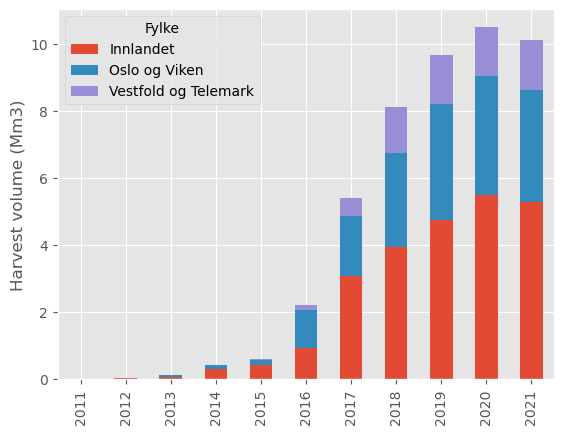

In [25]:
# Pivot your DataFrame
df_pivot = df2.pivot(index="year", columns="Fylke", values="Harvest volume (Mm3)")

# Plot a stacked bar chart
df_pivot.plot(kind="bar", stacked=True)

plt.xlabel("")
plt.ylabel("Harvest volume ($Mm^3$)")
plt.savefig(r"./images/harvest_vol_by_fylke.png", dpi=200, bbox_inches='tight')